Baseline Happiness:
mean  = 6.828
stdev = 1.761

Lonely Happiness:
mean  = 5.290
stdev = 2.348

Sick Happiness:
mean  = 3.204
stdev = 1.441

Healthy contacts/day:
mean  = 25.880
stdev = 19.396

Sick contacts/day:
mean  = 15.547
stdev = 12.598

Days sick:
Mean  = 7.185
stdev = 5.773

Step 1: Build SIR Model for Olin
    - Use Survey data:
        - Contact Rate
        - Recovery Speed
        - Infection Rate
    
    
Step 2: Add Quarantine
    - Keep a working version without Quarrantine
    - I -> Q
    - Can only infect roommate?
        - 1 interaction per day


Step 3: Create Happines
    - Assign baseline happiness
    - Calculate lonliness and sadness modifiers
    - Stretch Goal: Stress Strain model to account for missing work/length of quarrantine
    

Step 4: Integrate Happiness
    - Being sick = less happy
    - Being alone = less happy
    - Being sick and alone = lonliness modifier * sickness modifier
    
    
Step 5: Add Quarrantine Agressiveness Params
    - Quarantine Lengths
    - False Positives for Symptoms?
    - Random Pre-Emptive Isolation???


Step 6: Sweep Quarantine Agressiveness
    - Multiple Line plots ranging from no quarantine to putting everyone in little platic bubbles from day 1
    - 3D plot for 2x sweep of length and preemptiveness 
    
    
Step 7: Everything is a normal distribution


Step 8: git push origin master

In [1]:
#import all the libraries
from modsim import *
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

In [197]:
T_0    = 0.0

#first semester is 111 days spent at olin
T_END  = 111.0

dt     = 1/24

pop    = 380.0

#Assume Symptomns appear after 3 days, days sick = reported vale + 3
t_sick = 7.185 + 3

#Quarrantine Rate 
#Assume Symptoms take 3 days to apear 
#and students are quarrantined 2 days after symptoms appear
alpha = (t_sick-10)/t_sick

#Contact Rate
#Beta value selected so that total infected matches repoted valye (.583)
beta  = 0.1618869

#Recovery Rate = 1/Days Sick
gamma = 1/t_sick

#Quarrantined Recovery Rate
#Students ride out the rest of their illness stuck in their room
#Again assume 
delta = 1/(t_sick-10)



5.405405405405443

**Chapter 13 Slightly Derivative Stuff**

In [151]:
def make_system(beta, gamma):
    """Make a system object for the SIR model.
    
    beta: contact rate in days
    gamma: recovery rate in days
    
    returns: System object
    """
    init = State(S=pop-1, I=1, R=0)
    init /= np.sum(init)

    return System(init=init, t_0=T_0, t_end=T_END,
                  beta=beta, gamma=gamma)

In [152]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
        
    system: System object
    update_func: function that updates state
    
    returns: TimeFrame
    """
    unpack(system)
    
    frame = TimeFrame(columns=init.index)
    frame.row[t_0] = init
    
    for t in linrange(t_0, t_end):
        frame.row[t+1] = update_func(frame.row[t], t, system)
    
    return frame

In [153]:
def plot_SIR(frame):
    """Plot the results of a SIR model.
    
    S: TimeSeries
    I: TimeSeries
    R: TimeSeries
    """
    
    #S, I, R = frame
    
    plot(frame.S, '--', label='Susceptible')
    plot(frame.I, '-', label='Infected')
    plot(frame.R, ':', label='Recovered')
    decorate(xlabel='Time (days)',
             ylabel='Fraction of population')

In [154]:
def update_func(state, t, system):
    """Update the SIR model.
    
    state: State (s, i, r)
    t: time
    system: System object
    
    returns: State (sir)
    """
    s, i, r = state

    for n in range (int(1/dt)):
        infected = system.beta * i * s    
        recovered = system.gamma * i
    
        s -= infected
        i += infected - recovered
        r += recovered
    
    return State(S=s, I=i, R=r)

In [155]:
def slope_SIR(state, t, system):
    """Update the SIR model.
    
    state: State (s, i, r)
    t: time
    system: System object
    
    returns: State (sir)
    """
    s, i, r = state

    dSdt = -system.beta * i * s
    dIdt = system.beta * i * s - system.gamma * i
    dRdt = system.gamma * i

    
    return dSdt, dIdt, dRdt

In [156]:
def calc_total_infected(results):
    """Fraction of population infected during the simulation.
    
    results: DataFrame with columns S, I, R
    
    returns: fraction of population
    """
    return get_first_value(results.S) - get_last_value(results.S)

**Things That Are Fun, New, and Exciting!**

**Step 1**

0.5830255167589706

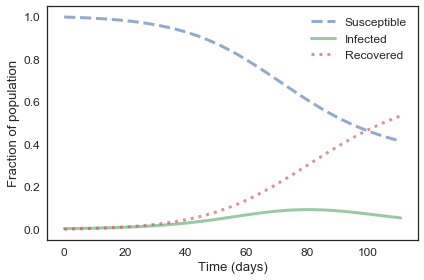

In [179]:
sir = make_system(beta, gamma)
results, details = run_ode_solver(sir, 
                                  slope_SIR, 
                                  t_eval = linrange(system.t_0, system.t_end, dt)
                                 )

plot_SIR(results)
results.head
#details
calc_total_infected(results)

**Step 2**


Main issue with quarrantine model = stops disease far to effectively and quickly. Wai

In [198]:
def make_system_Q(alpha, beta, gamma, delta):
    """Make a system object for the SIR model.
    
    beta: contact rate in days
    gamma: recovery rate in days
    
    returns: System object
    """
    init = State(S=pop-1, I=1, R=0, Q=0)
    init /= np.sum(init)

    return System(init=init, t_0=T_0, t_end=T_END,
                  alpha=alpha, beta=beta, gamma=gamma, delta=delta)

In [199]:
def slope_SIRQ(state, t, system):
    """Update the SIR model.
    
    state: State (s, i, r)
    t: time
    system: System object
    
    returns: State (sir)
    """
    s, i, r, q = state
    
    dSdt = -system.beta * i * s
    dIdt = system.beta * i * s - system.gamma * i - system.alpha * i
    dRdt = system.gamma * i + system.delta * q
    dQdt = system.alpha * i - system.delta * q
    

    
    return dSdt, dIdt, dRdt, dQdt

In [200]:
def plot_SIRQ(frame):
    """Plot the results of a SIR model.
    
    S: TimeSeries
    I: TimeSeries
    R: TimeSeries
    Q: TimeSeries
    """

    
    plot(frame.S, '--', label='Susceptible')
    plot(frame.I, '-', label='Infected')
    plot(frame.R, ':', label='Recovered')
    plot(frame.Q, '-o', label='Quarrantined')
    decorate(xlabel='Time (days)',
             ylabel='Fraction of population')

0.3613296920722586

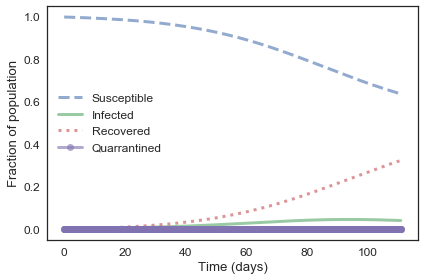

In [201]:
sirq = make_system_Q(alpha, beta, gamma, delta)
results, details = run_ode_solver(sirq, 
                                  slope_SIRQ, 
                                  t_eval = linrange(system.t_0, system.t_end, dt)
                                 )

plot_SIRQ(results)
results.head
#details
calc_total_infected(results)

**Step 3**

In [8]:
#code

**Step 4**

In [9]:
#code

**Step 5**

In [10]:
#code

**Step 6**

In [11]:
#code

**Step 7**

In [12]:
#code